In [1]:
"""
Cats vs. Dogs Classification using Transfer Learning (VGG16)
Author: [Your Name/GitHub Handle]
Description: A binary classifier leveraging the VGG16 architecture,
utilizing data augmentation and two-phase fine-tuning for high accuracy.
"""

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [2]:
# Download the dataset from Google's MLCC repository
print("Downloading Cats vs Dogs dataset...")
_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL)

# Define extraction path and unzip the data
extract_path = '/tmp/cats_and_dogs_project'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths for training and validation sets
PATH = os.path.join(extract_path, 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(validation_dir))

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train folders: ['dogs', 'cats']
Validation folders: ['dogs', 'cats']


In [3]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Training generator with Augmentation (Rotation, Zoom, Flips)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation generator (only preprocessing, no augmentation)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Load pre-trained VGG16 without the top classification layer
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model to preserve ImageNet weights during Phase 1
base_model.trainable = False

# Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Helps prevent overfitting
    layers.Dense(1, activation='sigmoid') # Binary output
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Compile for initial training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks to handle training plateaus and early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

print("\nPhase 1: Training top layers...")
history_phase1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Phase 1: Training top layers...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 475ms/step - accuracy: 0.6529 - loss: 1.7413 - val_accuracy: 0.9390 - val_loss: 0.1886 - learning_rate: 1.0000e-04
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.8888 - loss: 0.3810 - val_accuracy: 0.9530 - val_loss: 0.1476 - learning_rate: 1.0000e-04
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.9166 - loss: 0.2806 - val_accuracy: 0.9640 - val_loss: 0.1244 - learning_rate: 1.0000e-04
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9359 - loss: 0.2006 - val_accuracy: 0.9690 - val_loss: 0.1195 - learning_rate: 1.0000e-04
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.9350 - loss: 0.2157 - val_accuracy: 0.9610 - val_loss: 0.1192 - learning_rate: 1.0000e-04
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.9461 - loss: 0.1627 - val_accuracy: 0.9690 - val_loss: 0.1139 - learning_rate: 1.0000e-04
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - acc

In [6]:
print("\nPhase 2: Fine-tuning VGG16...")

# Unfreeze the base model
base_model.trainable = True

# Freeze the lower layers, fine-tune only the last 2 convolutional blocks (8 layers)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Phase 2: Fine-tuning VGG16...
Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 440ms/step - accuracy: 0.9500 - loss: 0.1500 - val_accuracy: 0.9720 - val_loss: 0.0890 - learning_rate: 1.0000e-05
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.9589 - loss: 0.1142 - val_accuracy: 0.9810 - val_loss: 0.0684 - learning_rate: 1.0000e-05
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.9782 - loss: 0.0531 - val_accuracy: 0.9660 - val_loss: 0.0993 - learning_rate: 1.0000e-05
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9739 - loss: 0.0736 - val_accuracy: 0.9830 - val_loss: 0.0574 - learning_rate: 1.0000e-05
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9764 - loss: 0.0586 - val_accuracy: 0.9780 - val_loss: 0.0692 - learning_rate: 1.0000e-05
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.9836 - loss: 0.0405 - val_accuracy: 0.9760 - val_loss: 0.0658 - learning_rate: 1.0000e-05
Epoch 7/15
63/63 ━━━━━━━━━━

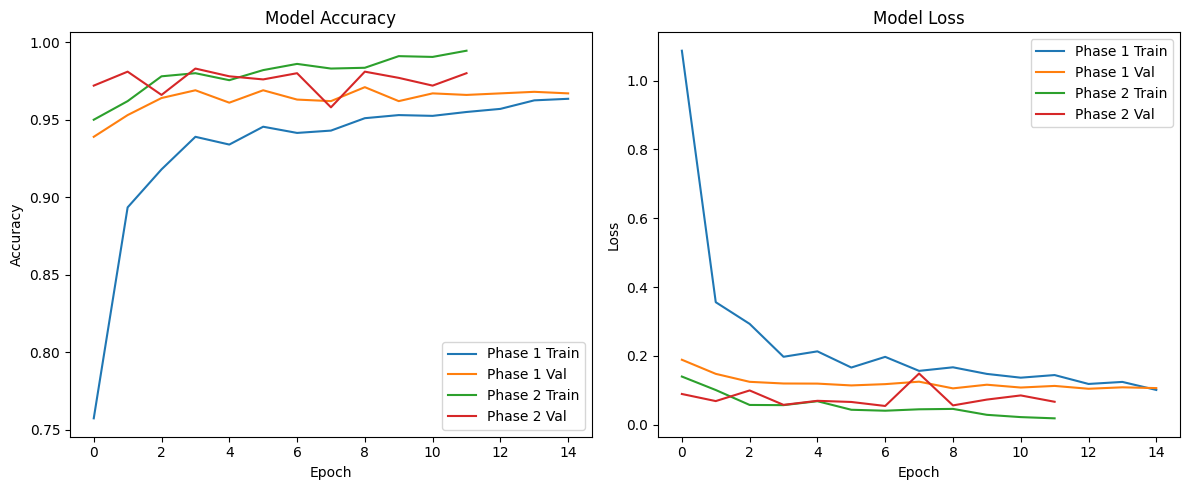


Final validation accuracy: 0.9800 (98.00%)
Project Completed.


In [7]:
def plot_history(histories, titles):
    plt.figure(figsize=(12, 5))
    for i, hist in enumerate(histories):
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Display plots
plot_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])

# Final validation evaluation
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal validation accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("Project Completed.")